# Prepare environment

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets

# Stratified split
from sklearn.model_selection import train_test_split

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 18}
matplotlib.rc('font', **font)

# Prepare datasets

In [2]:
# Download training data from open datasets.
train_ds = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=T.ToTensor(),
)

# Download test data from open datasets.
test_ds = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=T.ToTensor(),
)

# Preparing for validaion test
train_indices, valid_indices, _, _ = train_test_split(
    range(len(train_ds)),
    train_ds.targets,
    test_size=10000
)
valid_ds = Subset(train_ds, valid_indices)
train_ds = Subset(train_ds, train_indices)

# Create data loaders
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Class mapping
classes = [
    'Airplane',
    'Automobile',
    'Bird',
    'Cat',
    'Deer',
    'Dog',
    'Frog',
    'Horse',
    'Ship',
    'Truck',
]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Report split sizes
print(f'Training set: {len(train_ds)} examples')
print(f'Validation set: {len(valid_ds)} examples')
print(f'Test set: {len(test_ds)} examples')

Training set: 40000 examples
Validation set: 10000 examples
Test set: 10000 examples


It is always a good idea to visualize the input and the label obtained from the DataLoader to make sure that the input data are as expected.

In [4]:
# Get one batch of data
for batch in train_dl:
    imgs, lbls = batch
    break

print(imgs.shape)
print(lbls.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


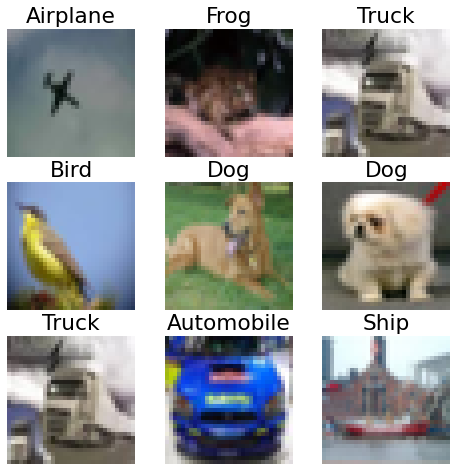

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(imgs), size=(1,)).item()
    img, label = imgs[sample_idx], lbls[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()

# Create a model

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 10)
        )

    def forward(self, x):
        # out = # YOUR CODE HERE
        logits = self.conv_stack(x)
        return logits

model = SimpleCNN().to(device)
print(model)

Using cpu device
SimpleCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=10, bias=True)
  )
)


Once you have created a model, it is always a good idea to try to process the input data from the DataLoader to make sure that we can train the model.

In [10]:
# Get one batch of data
for batch in train_dl:
    imgs, lbls = batch
    break

preds = model(imgs.to(device))
print(preds.shape)

torch.Size([64, 10])


# Train a model

In [11]:
# Specify loss
# Note: Make sure to check the following when choosing the loss
#   1. the label format of each loss (one-hot, ordinal, etc.)
#   2. classification or regression
loss_fn = nn.CrossEntropyLoss()

In [12]:
# Specify optimizer
# e.g., SGD, Adam, RMSProp, etc.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    # Size of the dataset
    size = len(dataloader.dataset)

    # Training mode
    model.train()

    # Keep track of the loss
    running_loss = 0.
    last_loss = 0.

    # We use enumerate to track the batch index
    for i, batch in enumerate(dataloader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        # Zeros the optimizer's gradient
        optimizer.zero_grad()

        # Prediction
        pred = model(X)

        # Compute loss
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # calculate the backward gradients
        optimizer.step()  # adjust model's weights based on the observed gradients

        # Keep track of the loss
        running_loss += loss.item()
        if (i+1) % 50 == 0:
            last_loss = running_loss / 50
            current = (i + 1) * len(X)
            print(f"loss: {last_loss:>7f}  [{current:>5d}/{size:>5d}]")
            running_loss = 0.

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Test mode
    model.eval()

    # Predict on test set
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Prediction
            pred = model(X)
            y_pred = pred.argmax(1)
            # Compute loss
            loss += loss_fn(pred, y).item()
            # Correct predictions
            correct += (y_pred == y).type(torch.float).sum().item()

    # Average loss
    loss /= num_batches

    # Accuracy
    accuracy = correct / size

    return loss, accuracy

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.
We also keep track of the validation loss, and save the model that perform best on the validation set.



In [15]:
epochs = 15
best_vloss = 100000.
hist = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dl, model, loss_fn, optimizer)
    train_loss, train_acc = test(train_dl, model, loss_fn)
    val_loss, val_acc = test(valid_dl, model, loss_fn)

    # History for learning curve
    hist['train_loss'].append(train_loss)
    hist['train_acc'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), 'model_best_vloss.pth')
        print('Saved best model to model_best_vloss.pth')
print("Done!")

Epoch 1
-------------------------------
loss: 2.138024  [ 3200/40000]
loss: 1.887721  [ 6400/40000]
loss: 1.745988  [ 9600/40000]
loss: 1.663311  [12800/40000]
loss: 1.595425  [16000/40000]
loss: 1.539504  [19200/40000]
loss: 1.497266  [22400/40000]
loss: 1.487655  [25600/40000]
loss: 1.455900  [28800/40000]
loss: 1.431284  [32000/40000]
loss: 1.400778  [35200/40000]
loss: 1.378853  [38400/40000]
Saved best model to model_best_vloss.pth
Epoch 2
-------------------------------
loss: 1.382093  [ 3200/40000]
loss: 1.365773  [ 6400/40000]
loss: 1.301516  [ 9600/40000]
loss: 1.303502  [12800/40000]
loss: 1.313625  [16000/40000]
loss: 1.324011  [19200/40000]
loss: 1.314800  [22400/40000]
loss: 1.323279  [25600/40000]
loss: 1.253664  [28800/40000]
loss: 1.282059  [32000/40000]
loss: 1.255881  [35200/40000]
loss: 1.269738  [38400/40000]
Saved best model to model_best_vloss.pth
Epoch 3
-------------------------------
loss: 1.214119  [ 3200/40000]
loss: 1.226795  [ 6400/40000]
loss: 1.223367  [ 

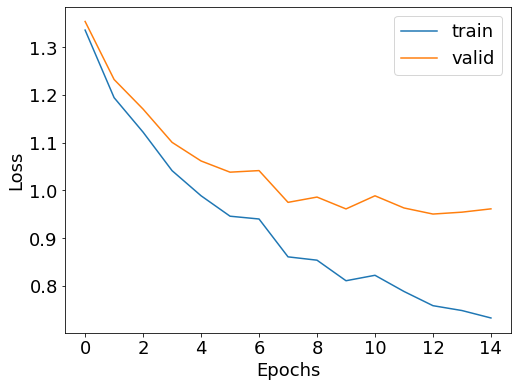

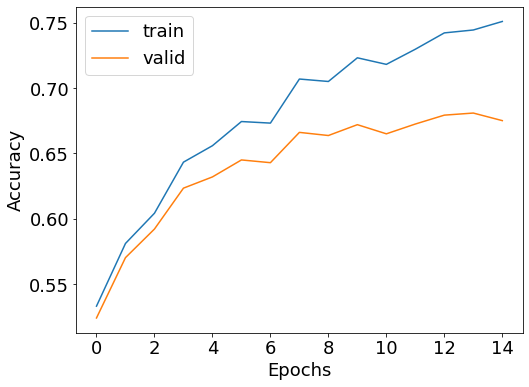

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hist['train_loss'], label='train')
ax.plot(hist['val_loss'], label='valid')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hist['train_acc'], label='train')
ax.plot(hist['val_acc'], label='valid')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

plt.close('all')

# Load Best Model on Validation Set



In [17]:
model_best = SimpleCNN().to(device)
model_best.load_state_dict(torch.load("model_best_vloss.pth"))

<All keys matched successfully>

# Evaluate on the test set

Predict on one example.



In [18]:
model_best.eval()

# Get one batch of data
for batch in test_dl:
    imgs, lbls = batch
    break

X, y = imgs[0:1].to(device), lbls[0:1].to(device)
with torch.no_grad():
    pred = model_best(X)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Cat", Actual: "Cat"


Predict on the whole test set.

In [19]:
# Use the best model on the validation set
test_loss, test_acc = test(test_dl, model_best, loss_fn)
print(f"Test: loss={test_loss:>8f}, acc={(100*test_acc):>0.1f}%")

Test: loss=0.956537, acc=67.4%


In [20]:
# Use the latest model
# Note: the latest model might be different from the best on validation set
test_loss, test_acc = test(test_dl, model, loss_fn)
print(f"Test: loss={test_loss:>8f}, acc={(100*test_acc):>0.1f}%")

Test: loss=0.970232, acc=67.0%
